# README

This is an example to illustrate how measurement notebooks could look like.
Of course this is easy to convert to a script, if you prefer working with spyder, for example.

Some things are not in a state yet that we're fully happy with, they're annotated correspondingly.

**TODO:** the initialization could be in a separate script or notebook. That would be useful if multiple notebooks run measurements, for example.

# Initialization

## Imports

In [1]:
%gui qt
%matplotlib inline

In [16]:
from pprint import pprint

import numpy as np
from matplotlib import pyplot as plt
import h5py


from qcodes import Instrument, Station, find_or_create_instrument
from plottr.data import datadict_storage as dds, datadict as dd

## Configuration

In [3]:
DATADIR = './data/'

## Create instruments

**TODO:** here we would prefer getting the instruments from the server.

In [4]:
# Create a new station, close all previous instruments
Instrument.close_all()
station = Station()

In [5]:
from instrumentserver.testing.dummy_instruments.rf import ResonatorResponse
vna = find_or_create_instrument(ResonatorResponse, 'vna')
station.add_component(vna)

vna.resonator_frequency(5e9)
vna.resonator_linewidth(10e6)

In [6]:
from instrumentserver.testing.dummy_instruments.rf import FluxControl
flux = find_or_create_instrument(FluxControl, 'flux', vna)
station.add_component(flux)

'flux'

# Flux-dependent resonator measurement

## Testing

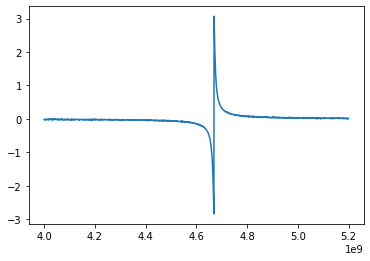

In [7]:
# just acquire a trace and plot. The resonance frequency should change when changing the flux.
vna.start_frequency(4e9)
vna.stop_frequency(5.2e9)
vna.npoints(1201)
vna.bandwidth(1e3)
vna.power(-50)
flux.flux(-0.25)

f_vals = vna.frequency()
s11_vals = vna.data()

fig, ax = plt.subplots(1, 1)
ax.plot(f_vals, np.angle(s11_vals))

## Measurement

**TODO:** This is using the bare file writer. Some things, like setting up the data structure will be made easier, but the new measurement structures are will work in progress.

**TODO:** This isn't saving meta data yet, or copying additional files. An easy way to circumvent that for the time being is by inheriting from the DDH5 writer.

In [24]:
# this is defining the data structure.
data = dd.DataDict(
    flux = dict(unit='Phi0'),
    frequency = dict(unit='Hz'),
    s11 = dict(axes=['flux', 'frequency']), # no unit, complex.
)
data.validate() # this is just for catching mistakes.

with dds.DDH5Writer(DATADIR, data, name='FluxSweep') as writer:
    for flux_val in np.linspace(-1,1,101):
        flux.flux(flux_val)
        
        # the writer accepts one line for each data field.
        # that means we should reshape the data that each entry has the form [<data>].
        # for practical purposes that means that each frequency and s11 data array
        # is like one datapoint.
        writer.add_data(
            flux = [flux_val],
            frequency = vna.frequency().reshape(1,-1),
            s11 = vna.data().reshape(1,-1),
        )

Data location:  ./data/2020-05-21/2020-05-21_0004_FluxSweep/2020-05-21_0004_FluxSweep.ddh5


### Inspecting the data

This is just to illustrate how to open and look at the data. You often would not actually do that in the measurement notebook.

Note that the data is currently also in the memory. **TODO**: an operation mode for not keeping the data in the memory is not implemented yet.

To illustrate, we look at the data in the memory, and compare with the file.

{'flux': {'axes': [], 'unit': 'Phi0'},
 'frequency': {'axes': [], 'unit': 'Hz'},
 's11': {'axes': ['flux', 'frequency'], 'unit': ''}}
{'flux': (101,), 'frequency': (101, 1201), 's11': (101, 1201)}
{'flux': {'axes': [], 'unit': 'Phi0'},
 'frequency': {'axes': [], 'unit': 'Hz'},
 's11': {'axes': ['flux', 'frequency'], 'unit': ''}}
{'flux': (101, 1201), 'frequency': (101, 1201), 's11': (101, 1201)}


Text(0, 0.5, 'Frequency (Hz)')

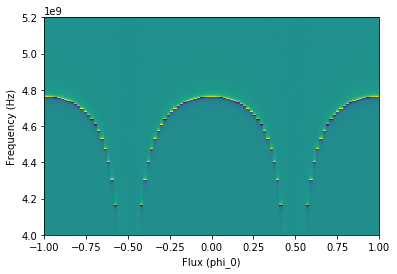

In [31]:
# when we look at the data now, we see it's not on a grid, even though we want the data to be.
pprint(data.structure())
pprint(data.shapes())

# this is detecting the grid in the data
data_as_grid = dd.datadict_to_meshgrid(data)
pprint(data_as_grid.structure())
pprint(data_as_grid.shapes())

flux_data = data_as_grid.data_vals('flux')
frq_data = data_as_grid.data_vals('frequency')
s11_data = data_as_grid.data_vals('s11')

fig, ax = plt.subplots(1, 1)

ax.imshow(
    np.angle(s11_data.T), 
    aspect='auto', origin='lower',
    extent=[flux_data.min(), flux_data.max(), frq_data.min(), frq_data.max()]
)
ax.set_xlabel('Flux (phi_0)')
ax.set_ylabel('Frequency (Hz)')

Text(0, 0.5, 'Frequency (Hz)')

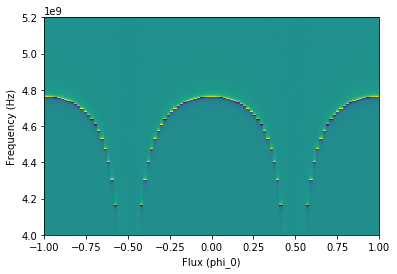

In [32]:
# Loading from file is essentiall the same thing:
data_from_file = dds.datadict_from_hdf5(writer.file_path)
data_as_grid = dd.datadict_to_meshgrid(data_from_file)

flux_data = data_as_grid.data_vals('flux')
frq_data = data_as_grid.data_vals('frequency')
s11_data = data_as_grid.data_vals('s11')

fig, ax = plt.subplots(1, 1)

ax.imshow(
    np.angle(s11_data.T), 
    aspect='auto', origin='lower',
    extent=[flux_data.min(), flux_data.max(), frq_data.min(), frq_data.max()]
)
ax.set_xlabel('Flux (phi_0)')
ax.set_ylabel('Frequency (Hz)')